## 1. Setup and imports
Load all necessary libraries for testing and visualization.

In [5]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Statistical tests and metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats

# SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Load and prepare data
Load Delhi AQI data and create train/test splits.

In [6]:
# Load data
df = pd.read_csv("../datasets/city_day.csv", parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

# Filter Delhi and prepare
delhi = df[df['City'] == 'Delhi'][['Date', 'AQI']].copy()
delhi.set_index('Date', inplace=True)
delhi['AQI'] = delhi['AQI'].bfill()
delhi = delhi.astype('float64')
delhi = delhi.resample('MS').mean()

print(f"Total months: {len(delhi)}")
print(f"Date range: {delhi.index.min()} to {delhi.index.max()}")
print(f"AQI range: {delhi['AQI'].min():.2f} to {delhi['AQI'].max():.2f}")

# Split data
train_size = 48
test_size = 13

train = delhi[:train_size]
test = delhi[train_size:train_size+test_size]

print(f"\nTrain: {len(train)} months")
print(f"Test: {len(test)} months")

delhi.tail()

Total months: 67
Date range: 2015-01-01 00:00:00 to 2020-07-01 00:00:00
AQI range: 67.16 to 474.83

Train: 48 months
Test: 13 months


,AQI
Date,
2020-03-01,135.838710
2020-04-01,113.000000
2020-05-01,148.645161
2020-06-01,125.733333
2020-07-01,101.000000


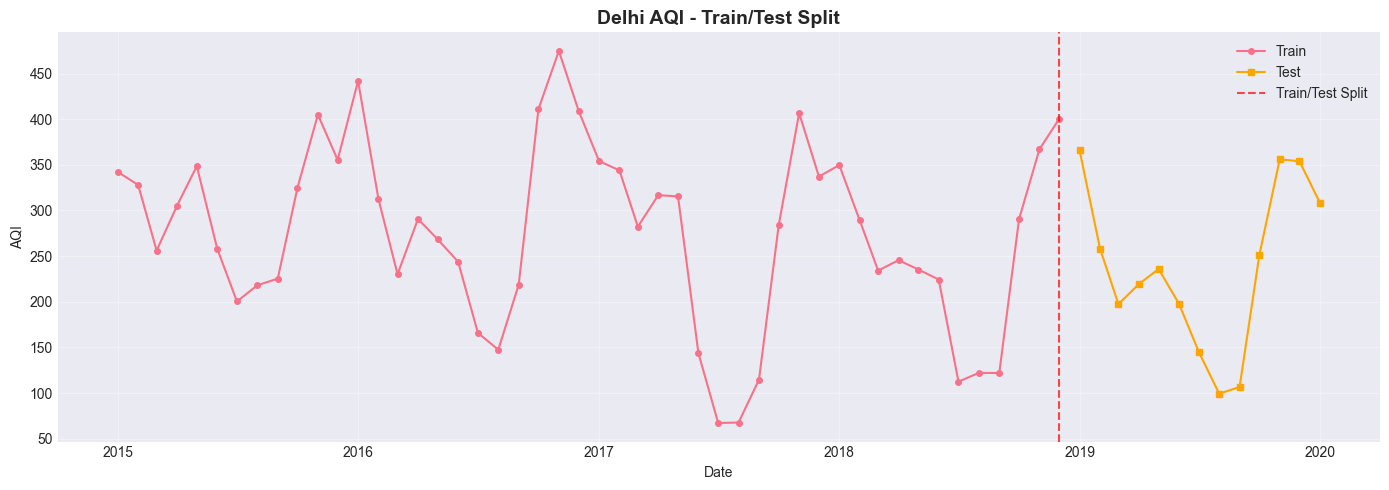

In [7]:
# Visualize train/test split
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['AQI'], label='Train', marker='o', markersize=4)
plt.plot(test.index, test['AQI'], label='Test', marker='s', markersize=4, color='orange')
plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.title('Delhi AQI - Train/Test Split', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. SARIMA model testing
Fit SARIMA, check residuals, and validate assumptions.

In [8]:
# Fit SARIMA model
sarima_model = SARIMAX(train['AQI'], order=(0,1,3), seasonal_order=(0,1,1,12))
sarima_results = sarima_model.fit(disp=False)

print("SARIMA Model Summary:")
print(sarima_results.summary())

SARIMA Model Summary:
                                      SARIMAX Results                                       
Dep. Variable:                                  AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -185.444
Date:                              Mon, 08 Dec 2025   AIC                            380.888
Time:                                      21:02:12   BIC                            388.665
Sample:                                  01-01-2015   HQIC                           383.573
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5591      8.143     -0.069      0.945     -16.519      15.4

In [9]:
# Generate predictions
sarima_train_pred = sarima_results.predict(start=1, end=len(train), typ='levels')
sarima_test_pred = sarima_results.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

# Calculate metrics
sarima_train_rmse = np.sqrt(mean_squared_error(train['AQI'], sarima_train_pred))
sarima_train_mae = mean_absolute_error(train['AQI'], sarima_train_pred)

sarima_test_rmse = np.sqrt(mean_squared_error(test['AQI'], sarima_test_pred))
sarima_test_mae = mean_absolute_error(test['AQI'], sarima_test_pred)
sarima_test_mape = np.mean(np.abs((test['AQI'].values - sarima_test_pred.values) / test['AQI'].values)) * 100

print("\n=== SARIMA Performance ===")
print(f"Train RMSE: {sarima_train_rmse:.2f}")
print(f"Train MAE:  {sarima_train_mae:.2f}")
print(f"\nTest RMSE:  {sarima_test_rmse:.2f}")
print(f"Test MAE:   {sarima_test_mae:.2f}")
print(f"Test MAPE:  {sarima_test_mape:.2f}%")


=== SARIMA Performance ===
Train RMSE: 66.39
Train MAE:  47.57

Test RMSE:  26.88
Test MAE:   22.77
Test MAPE:  11.14%


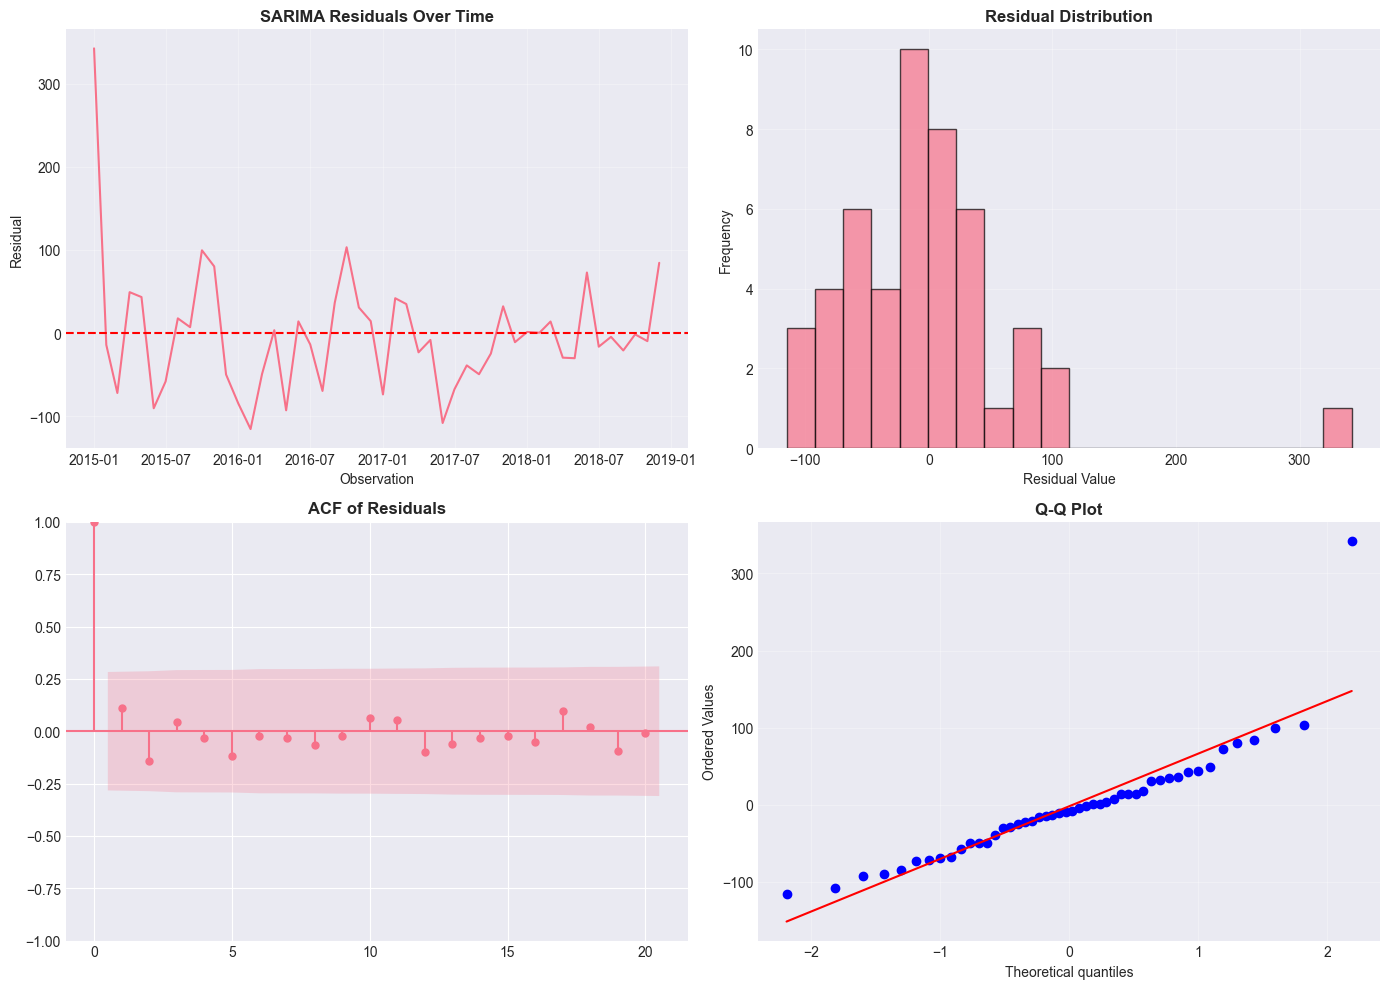

In [10]:
# Residual diagnostics
residuals = sarima_results.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual plot
axes[0, 0].plot(residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('SARIMA Residuals Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Observation')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(True, alpha=0.3)

# Histogram
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Residual Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Residual Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# ACF
plot_acf(residuals, lags=20, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontweight='bold')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Ljung-Box test for residual autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
print("\nLjung-Box Test (H0: residuals are independent):")
print(lb_test)
print("\nInterpretation: p-value > 0.05 suggests residuals are independent (good)")


Ljung-Box Test (H0: residuals are independent):
     lb_stat  lb_pvalue
10  3.275861   0.974167
20  6.139254   0.998696

Interpretation: p-value > 0.05 suggests residuals are independent (good)


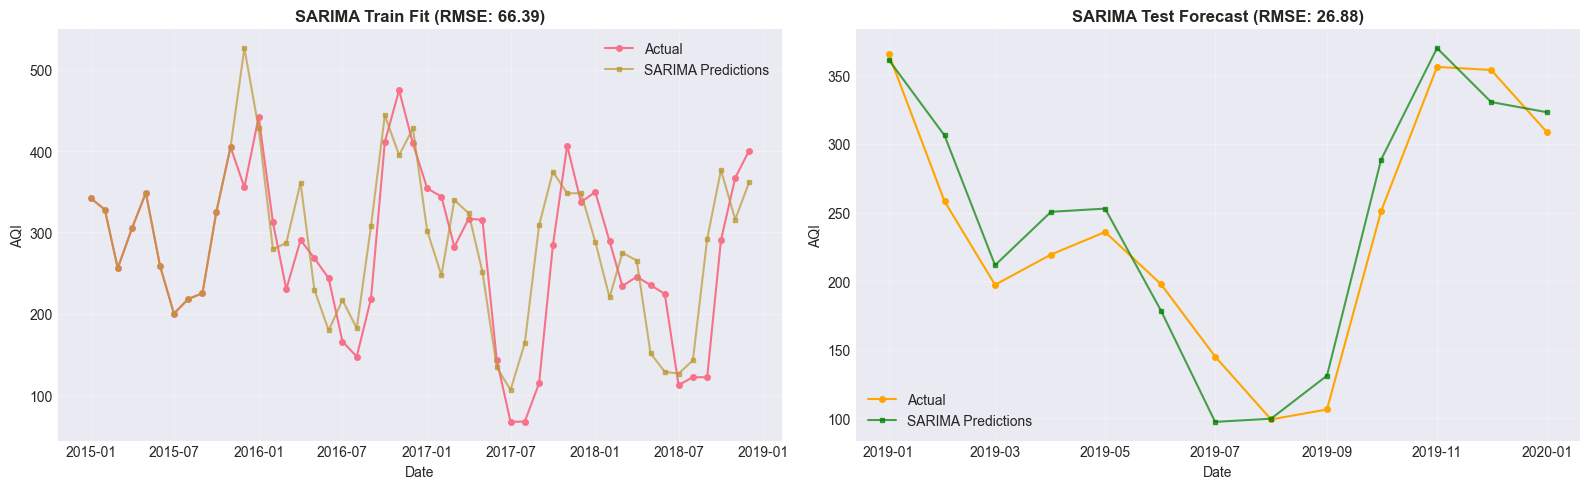

In [12]:
# SARIMA forecast visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Train predictions
ax1.plot(train.index, train['AQI'], label='Actual', marker='o', markersize=4)
ax1.plot(train.index, sarima_train_pred, label='SARIMA Predictions', marker='s', markersize=3, alpha=0.7)
ax1.set_title(f'SARIMA Train Fit (RMSE: {sarima_train_rmse:.2f})', fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('AQI')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test predictions
ax2.plot(test.index, test['AQI'], label='Actual', marker='o', markersize=4, color='orange')
ax2.plot(test.index, sarima_test_pred, label='SARIMA Predictions', marker='s', markersize=3, alpha=0.7, color='green')
ax2.set_title(f'SARIMA Test Forecast (RMSE: {sarima_test_rmse:.2f})', fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('AQI')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. LSTM model testing
Build, train, and evaluate LSTM with detailed diagnostics.

In [13]:
# Prepare data for LSTM
scaler = MinMaxScaler()
scaler.fit(train[['AQI']])

scaled_train = scaler.transform(train[['AQI']])
scaled_test = scaler.transform(test[['AQI']])

# Create sequences
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(f"Sequence length: {n_input} months")
print(f"Number of training sequences: {len(generator)}")

Sequence length: 12 months
Number of training sequences: 36


In [14]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(32, activation='relu', return_sequences=True, input_shape=(n_input, n_features), name='LSTM_1'),
    LSTM(32, activation='relu', name='LSTM_2'),
    Dense(1, name='Output')
], name='LSTM-AQI-Forecaster')

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "LSTM-AQI-Forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 12, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train LSTM
history = lstm_model.fit(generator, epochs=50, verbose=0)
print("✓ LSTM training complete")

✓ LSTM training complete


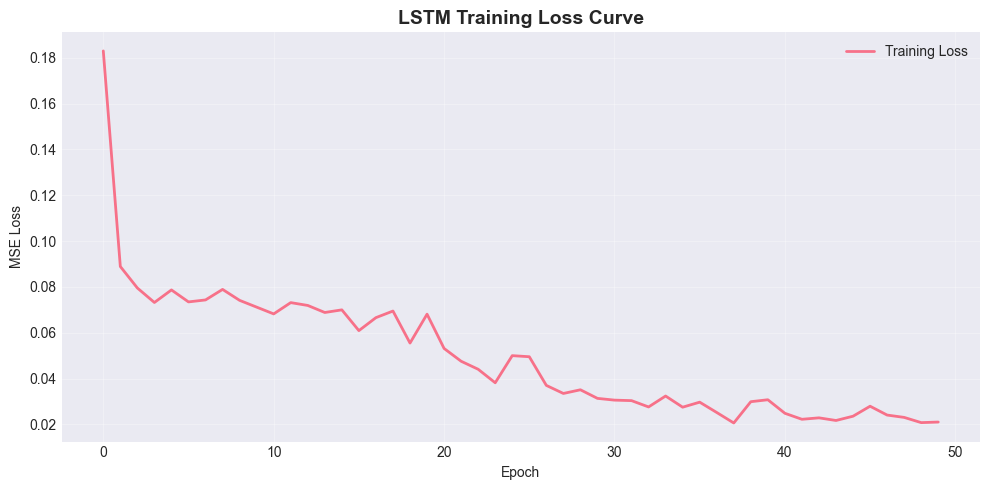

Final training loss: 0.021013


In [16]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.title('LSTM Training Loss Curve', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final training loss: {history.history['loss'][-1]:.6f}")

In [17]:
# Generate LSTM predictions for test set
lstm_test_predictions = []
first_batch = scaled_train[-n_input:]
current_batch = first_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = lstm_model.predict(current_batch, verbose=0)[0]
    lstm_test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

lstm_test_predictions = scaler.inverse_transform(lstm_test_predictions)

# Calculate metrics
lstm_test_rmse = np.sqrt(mean_squared_error(test['AQI'], lstm_test_predictions))
lstm_test_mae = mean_absolute_error(test['AQI'], lstm_test_predictions)
lstm_test_mape = np.mean(np.abs((test['AQI'].values - lstm_test_predictions.flatten()) / test['AQI'].values)) * 100

print("\n=== LSTM Performance ===")
print(f"Test RMSE: {lstm_test_rmse:.2f}")
print(f"Test MAE:  {lstm_test_mae:.2f}")
print(f"Test MAPE: {lstm_test_mape:.2f}%")


=== LSTM Performance ===
Test RMSE: 35.64
Test MAE:  30.82
Test MAPE: 15.48%


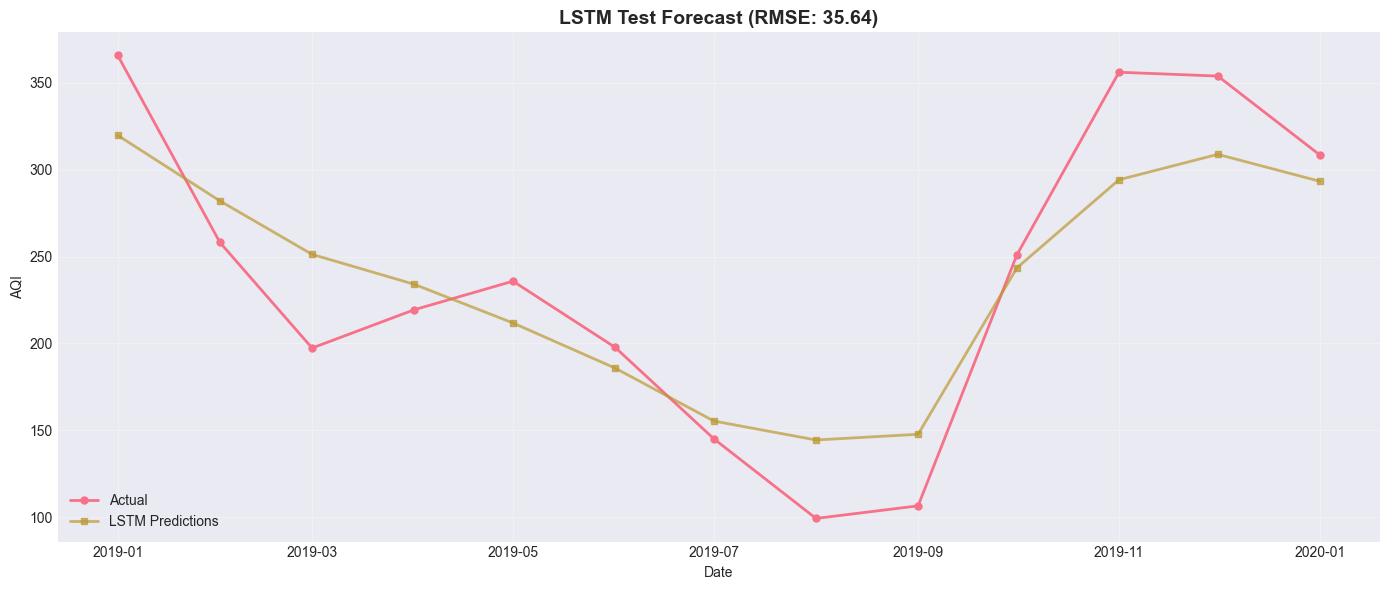

In [18]:
# LSTM forecast visualization
plt.figure(figsize=(14, 6))
plt.plot(test.index, test['AQI'], label='Actual', marker='o', markersize=5, linewidth=2)
plt.plot(test.index, lstm_test_predictions, label='LSTM Predictions', marker='s', markersize=4, alpha=0.7, linewidth=2)
plt.title(f'LSTM Test Forecast (RMSE: {lstm_test_rmse:.2f})', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

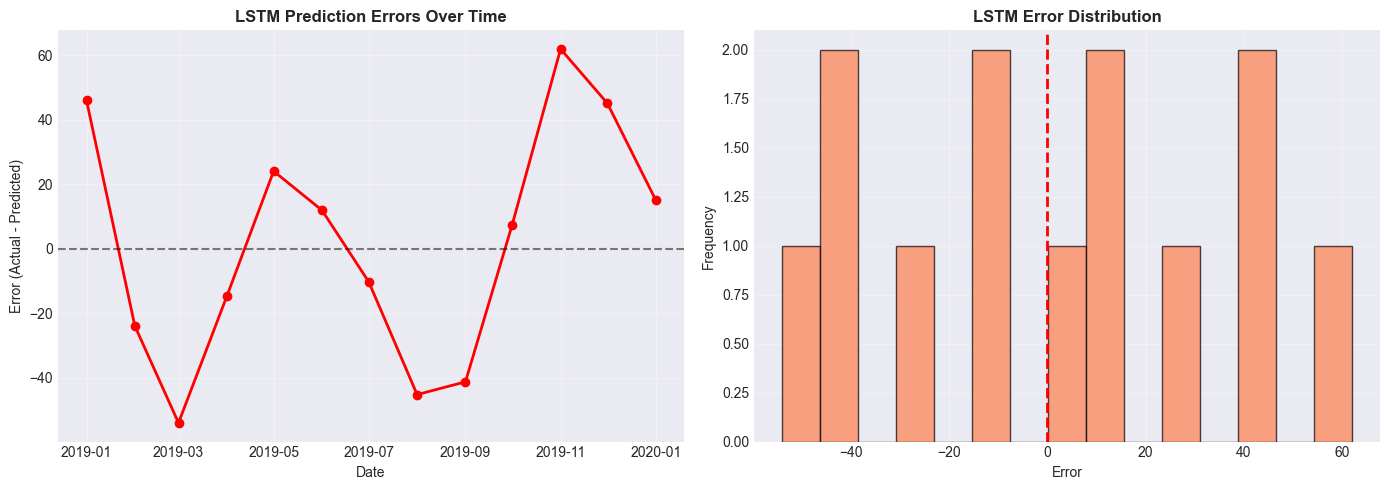

Mean error: 1.73
Std dev of errors: 35.60


In [19]:
# LSTM prediction errors
lstm_errors = test['AQI'].values - lstm_test_predictions.flatten()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error over time
axes[0].plot(test.index, lstm_errors, marker='o', linewidth=2, color='red')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].set_title('LSTM Prediction Errors Over Time', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Error (Actual - Predicted)')
axes[0].grid(True, alpha=0.3)

# Error distribution
axes[1].hist(lstm_errors, bins=15, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_title('LSTM Error Distribution', fontweight='bold')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean error: {lstm_errors.mean():.2f}")
print(f"Std dev of errors: {lstm_errors.std():.2f}")

## 5. Prophet model testing
Fit Prophet, evaluate components, and run cross-validation.

In [20]:
# Prepare data for Prophet
prophet_train = train.reset_index().rename(columns={'Date': 'ds', 'AQI': 'y'})
prophet_test = test.reset_index().rename(columns={'Date': 'ds', 'AQI': 'y'})

# Fit Prophet model
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(prophet_train)

print("✓ Prophet model fitted")

21:02:24 - cmdstanpy - INFO - Chain [1] start processing
21:02:25 - cmdstanpy - INFO - Chain [1] done processing
21:02:25 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet model fitted


In [21]:
# Generate predictions
prophet_forecast = prophet_model.predict(prophet_test)

# Calculate metrics
prophet_test_rmse = np.sqrt(mean_squared_error(prophet_test['y'], prophet_forecast['yhat']))
prophet_test_mae = mean_absolute_error(prophet_test['y'], prophet_forecast['yhat'])
prophet_test_mape = np.mean(np.abs((prophet_test['y'].values - prophet_forecast['yhat'].values) / prophet_test['y'].values)) * 100

print("\n=== Prophet Performance ===")
print(f"Test RMSE: {prophet_test_rmse:.2f}")
print(f"Test MAE:  {prophet_test_mae:.2f}")
print(f"Test MAPE: {prophet_test_mape:.2f}%")


=== Prophet Performance ===
Test RMSE: 24.49
Test MAE:  20.05
Test MAPE: 10.61%


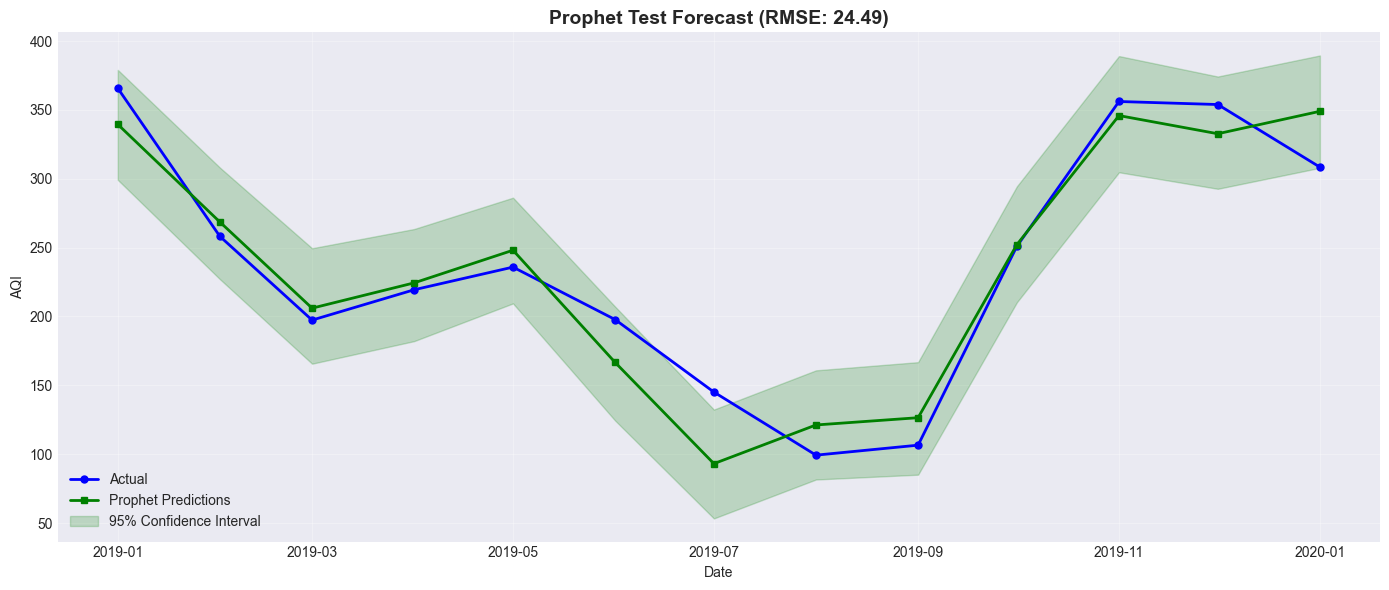

In [22]:
# Prophet forecast visualization
fig, ax = plt.subplots(figsize=(14, 6))

# Plot actual
ax.plot(prophet_test['ds'], prophet_test['y'], label='Actual', marker='o', markersize=5, linewidth=2, color='blue')

# Plot predictions with uncertainty
ax.plot(prophet_test['ds'], prophet_forecast['yhat'], label='Prophet Predictions', marker='s', markersize=4, linewidth=2, color='green')
ax.fill_between(prophet_test['ds'], 
                 prophet_forecast['yhat_lower'], 
                 prophet_forecast['yhat_upper'], 
                 alpha=0.2, color='green', label='95% Confidence Interval')

ax.set_title(f'Prophet Test Forecast (RMSE: {prophet_test_rmse:.2f})', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('AQI')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

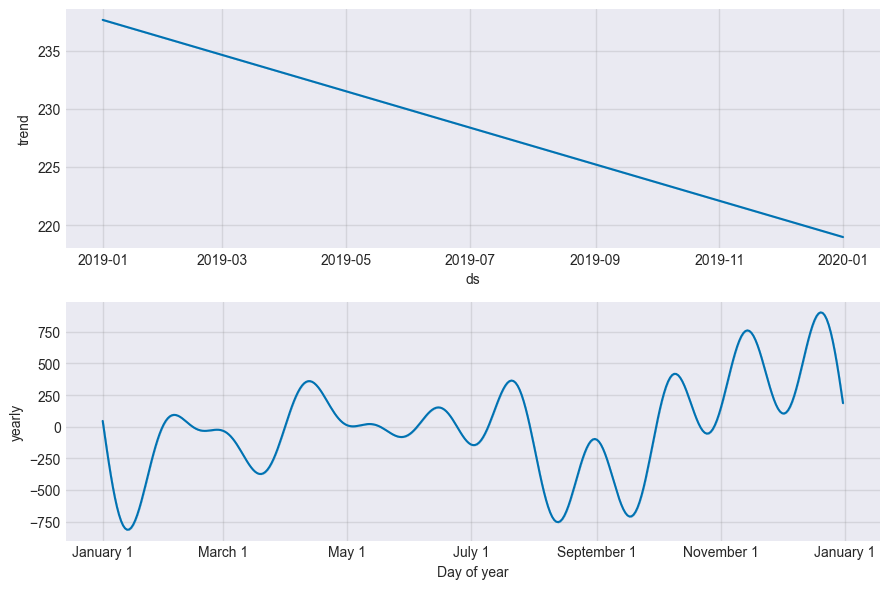

In [23]:
# Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.show()

In [24]:
# Prophet cross-validation
print("Running Prophet cross-validation...")
df_cv = cross_validation(prophet_model, initial='365 days', period='90 days', horizon='180 days')
df_p = performance_metrics(df_cv)

print("\nCross-validation metrics:")
print(df_p[['horizon', 'rmse', 'mae', 'mape']].head(10))

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Running Prophet cross-validation...


  0%|          | 0/10 [00:00<?, ?it/s]

21:02:25 - cmdstanpy - INFO - Chain [1] start processing
21:02:32 - cmdstanpy - INFO - Chain [1] done processing
21:02:32 - cmdstanpy - INFO - Chain [1] done processing
21:02:32 - cmdstanpy - INFO - Chain [1] start processing
21:02:32 - cmdstanpy - INFO - Chain [1] start processing
21:02:40 - cmdstanpy - INFO - Chain [1] done processing
21:02:40 - cmdstanpy - INFO - Chain [1] done processing
21:02:40 - cmdstanpy - INFO - Chain [1] start processing
21:02:40 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:51 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1]


Cross-validation metrics:
  horizon        rmse         mae      mape
0 22 days  423.034243  328.914069  1.295940
1 24 days  344.670973  239.537190  0.989349
2 26 days  115.265667   81.724586  0.471760
3 27 days   90.794672   61.156338  0.419937
4 46 days  497.481900  241.275588  1.110304
5 48 days  495.347715  225.200415  0.847066
6 50 days  494.574587  215.372993  0.810255
7 51 days  494.518303  214.603304  0.807808
8 52 days  495.827405  225.968621  0.839799
9 53 days  497.630114  242.186114  1.085983


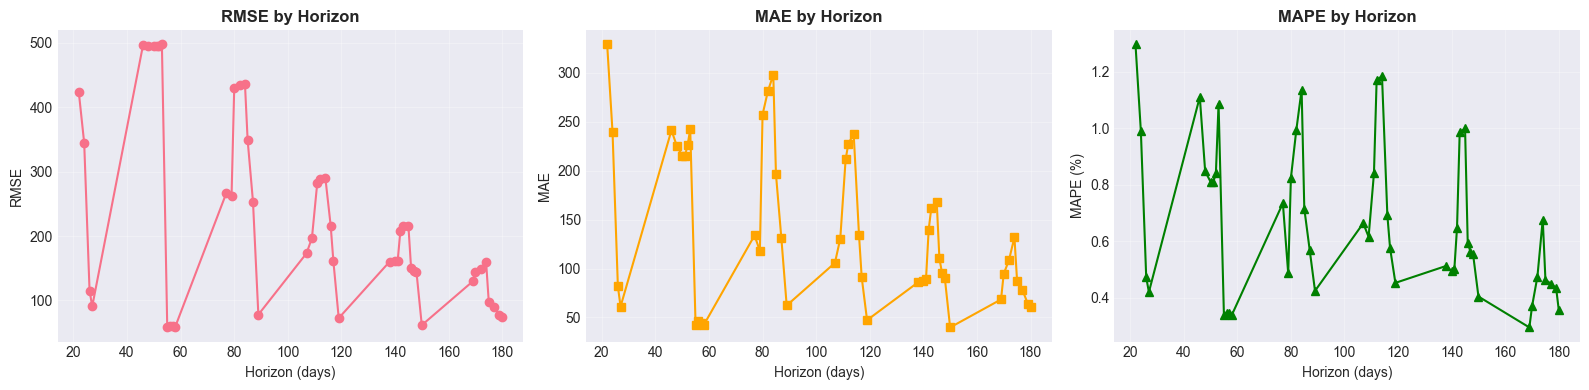

In [25]:
# Plot CV metrics
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

axes[0].plot(df_p['horizon'].dt.days, df_p['rmse'], marker='o')
axes[0].set_title('RMSE by Horizon', fontweight='bold')
axes[0].set_xlabel('Horizon (days)')
axes[0].set_ylabel('RMSE')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_p['horizon'].dt.days, df_p['mae'], marker='s', color='orange')
axes[1].set_title('MAE by Horizon', fontweight='bold')
axes[1].set_xlabel('Horizon (days)')
axes[1].set_ylabel('MAE')
axes[1].grid(True, alpha=0.3)

axes[2].plot(df_p['horizon'].dt.days, df_p['mape'], marker='^', color='green')
axes[2].set_title('MAPE by Horizon', fontweight='bold')
axes[2].set_xlabel('Horizon (days)')
axes[2].set_ylabel('MAPE (%)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Comparative analysis
Compare all three models side-by-side.

In [26]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['SARIMA', 'LSTM', 'Prophet'],
    'RMSE': [sarima_test_rmse, lstm_test_rmse, prophet_test_rmse],
    'MAE': [sarima_test_mae, lstm_test_mae, prophet_test_mae],
    'MAPE (%)': [sarima_test_mape, lstm_test_mape, prophet_test_mape]
})

print("\n=== Model Comparison (Test Set) ===")
print(comparison_df.to_string(index=False))

# Find best model
best_rmse_model = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
best_mae_model = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']
best_mape_model = comparison_df.loc[comparison_df['MAPE (%)'].idxmin(), 'Model']

print(f"\n✓ Best RMSE: {best_rmse_model}")
print(f"✓ Best MAE: {best_mae_model}")
print(f"✓ Best MAPE: {best_mape_model}")


=== Model Comparison (Test Set) ===
  Model      RMSE       MAE  MAPE (%)
 SARIMA 26.876746 22.773062 11.137779
   LSTM 35.641662 30.816630 15.482842
Prophet 24.486550 20.053772 10.608848

✓ Best RMSE: Prophet
✓ Best MAE: Prophet
✓ Best MAPE: Prophet


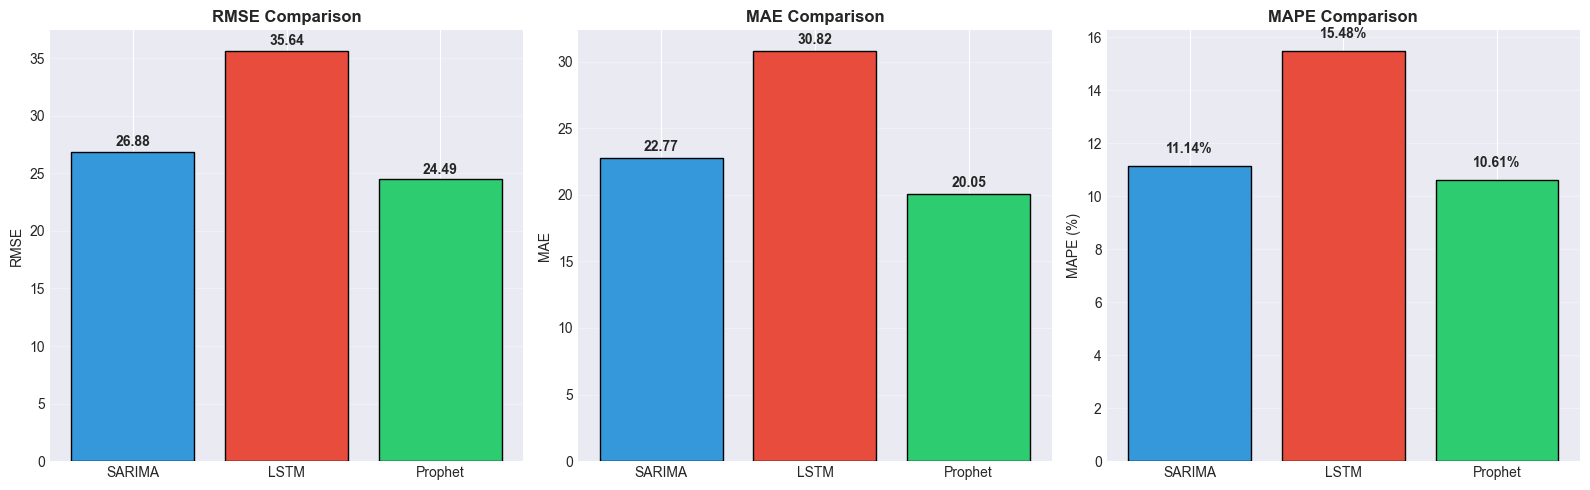

In [27]:
# Metric comparison bar charts
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# RMSE
axes[0].bar(comparison_df['Model'], comparison_df['RMSE'], color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[0].set_title('RMSE Comparison', fontsize=12, fontweight='bold')
axes[0].set_ylabel('RMSE')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['RMSE']):
    axes[0].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# MAE
axes[1].bar(comparison_df['Model'], comparison_df['MAE'], color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[1].set_title('MAE Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MAE')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['MAE']):
    axes[1].text(i, v + 0.5, f'{v:.2f}', ha='center', fontweight='bold')

# MAPE
axes[2].bar(comparison_df['Model'], comparison_df['MAPE (%)'], color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
axes[2].set_title('MAPE Comparison', fontsize=12, fontweight='bold')
axes[2].set_ylabel('MAPE (%)')
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['MAPE (%)']):
    axes[2].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

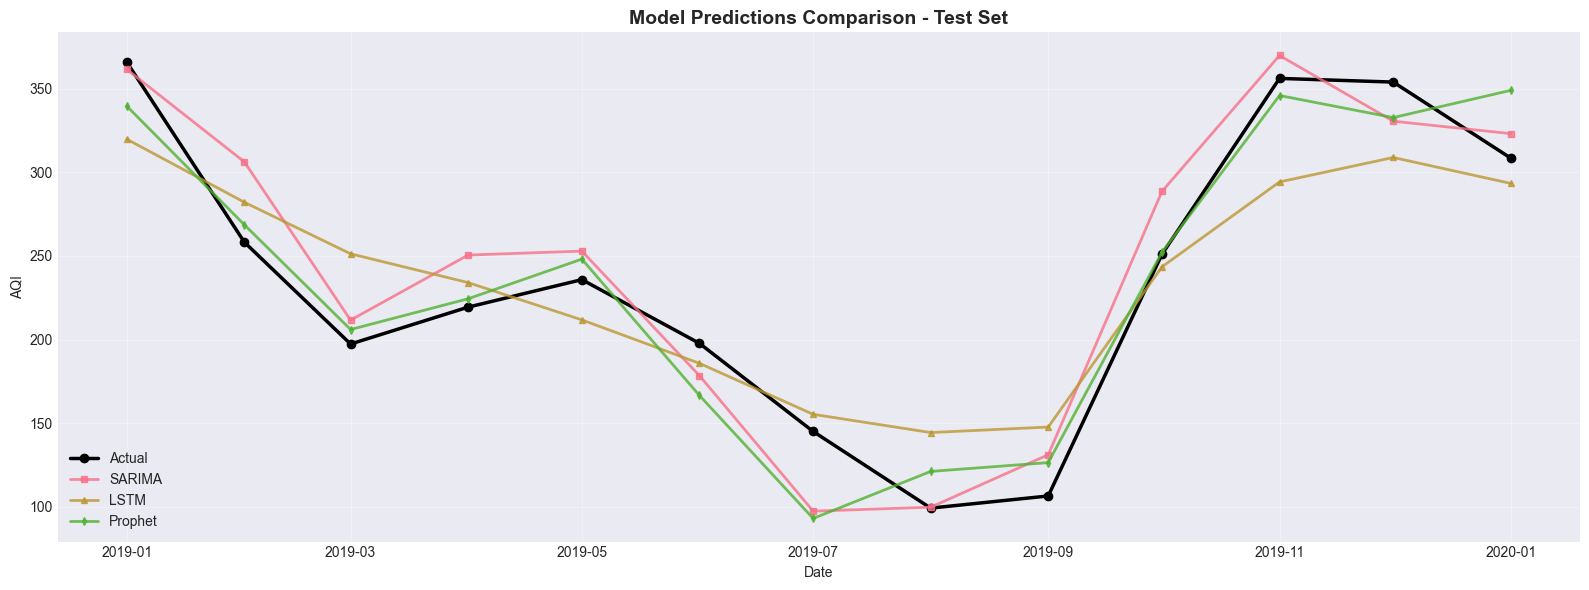

In [28]:
# All predictions overlay
plt.figure(figsize=(16, 6))
plt.plot(test.index, test['AQI'], label='Actual', marker='o', markersize=6, linewidth=2.5, color='black')
plt.plot(test.index, sarima_test_pred, label='SARIMA', marker='s', markersize=4, linewidth=2, alpha=0.8)
plt.plot(test.index, lstm_test_predictions, label='LSTM', marker='^', markersize=4, linewidth=2, alpha=0.8)
plt.plot(test.index, prophet_forecast['yhat'].values, label='Prophet', marker='d', markersize=4, linewidth=2, alpha=0.8)

plt.title('Model Predictions Comparison - Test Set', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Statistical tests and validation
Additional statistical validation for model reliability.

In [29]:
# Calculate prediction errors for all models
sarima_errors = test['AQI'].values - sarima_test_pred.values
lstm_errors = test['AQI'].values - lstm_test_predictions.flatten()
prophet_errors = test['AQI'].values - prophet_forecast['yhat'].values

# Normality test (Shapiro-Wilk)
print("\n=== Normality Tests (Shapiro-Wilk) ===")
print("H0: Errors are normally distributed\n")

sarima_shapiro = stats.shapiro(sarima_errors)
lstm_shapiro = stats.shapiro(lstm_errors)
prophet_shapiro = stats.shapiro(prophet_errors)

print(f"SARIMA: statistic={sarima_shapiro.statistic:.4f}, p-value={sarima_shapiro.pvalue:.4f}")
print(f"LSTM:   statistic={lstm_shapiro.statistic:.4f}, p-value={lstm_shapiro.pvalue:.4f}")
print(f"Prophet: statistic={prophet_shapiro.statistic:.4f}, p-value={prophet_shapiro.pvalue:.4f}")
print("\nInterpretation: p-value > 0.05 suggests errors are normally distributed (good)")


=== Normality Tests (Shapiro-Wilk) ===
H0: Errors are normally distributed

SARIMA: statistic=0.9613, p-value=0.7738
LSTM:   statistic=0.9607, p-value=0.7643
Prophet: statistic=0.9692, p-value=0.8848

Interpretation: p-value > 0.05 suggests errors are normally distributed (good)


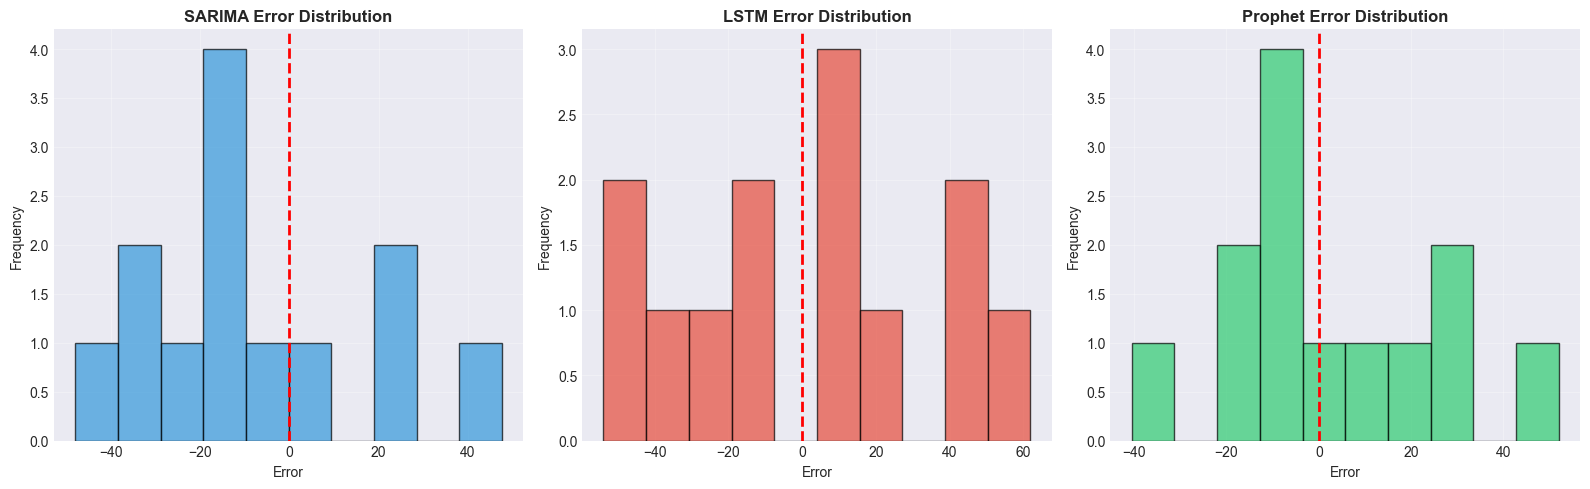

In [30]:
# Error distributions comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(sarima_errors, bins=10, edgecolor='black', alpha=0.7, color='#3498db')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('SARIMA Error Distribution', fontweight='bold')
axes[0].set_xlabel('Error')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, alpha=0.3)

axes[1].hist(lstm_errors, bins=10, edgecolor='black', alpha=0.7, color='#e74c3c')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('LSTM Error Distribution', fontweight='bold')
axes[1].set_xlabel('Error')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

axes[2].hist(prophet_errors, bins=10, edgecolor='black', alpha=0.7, color='#2ecc71')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_title('Prophet Error Distribution', fontweight='bold')
axes[2].set_xlabel('Error')
axes[2].set_ylabel('Frequency')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# Error statistics summary
error_stats = pd.DataFrame({
    'Model': ['SARIMA', 'LSTM', 'Prophet'],
    'Mean Error': [sarima_errors.mean(), lstm_errors.mean(), prophet_errors.mean()],
    'Std Dev': [sarima_errors.std(), lstm_errors.std(), prophet_errors.std()],
    'Min Error': [sarima_errors.min(), lstm_errors.min(), prophet_errors.min()],
    'Max Error': [sarima_errors.max(), lstm_errors.max(), prophet_errors.max()]
})

print("\n=== Error Statistics ===")
print(error_stats.to_string(index=False))
print("\nNote: Mean error close to 0 indicates unbiased predictions")


=== Error Statistics ===
  Model  Mean Error   Std Dev  Min Error  Max Error
 SARIMA   -8.227064 25.586615 -47.994377  47.621653
   LSTM    1.729741 35.599664 -53.917883  61.879969
Prophet    1.605885 24.433834 -40.520554  51.984691

Note: Mean error close to 0 indicates unbiased predictions


## 8. Final test report
Summary of all testing results and recommendations.

In [32]:
print("="*70)
print(" "*20 + "FINAL TEST REPORT")
print("="*70)

print("\n1. DATA SUMMARY")
print("-" * 70)
print(f"   City: Delhi")
print(f"   Total months: {len(delhi)}")
print(f"   Training period: {train.index[0].strftime('%Y-%m')} to {train.index[-1].strftime('%Y-%m')} ({len(train)} months)")
print(f"   Test period: {test.index[0].strftime('%Y-%m')} to {test.index[-1].strftime('%Y-%m')} ({len(test)} months)")
print(f"   AQI range: {delhi['AQI'].min():.1f} - {delhi['AQI'].max():.1f}")

print("\n2. MODEL PERFORMANCE (TEST SET)")
print("-" * 70)
print(comparison_df.to_string(index=False))

print("\n3. BEST MODELS BY METRIC")
print("-" * 70)
print(f"   Lowest RMSE:  {best_rmse_model} ({comparison_df.loc[comparison_df['RMSE'].idxmin(), 'RMSE']:.2f})")
print(f"   Lowest MAE:   {best_mae_model} ({comparison_df.loc[comparison_df['MAE'].idxmin(), 'MAE']:.2f})")
print(f"   Lowest MAPE:  {best_mape_model} ({comparison_df.loc[comparison_df['MAPE (%)'].idxmin(), 'MAPE (%)']:.2f}%)")

print("\n4. DIAGNOSTIC TEST RESULTS")
print("-" * 70)
print(f"   SARIMA Ljung-Box (lag 10): p-value = {lb_test.loc[10, 'lb_pvalue']:.4f}")
print(f"   SARIMA Normality (Shapiro): p-value = {sarima_shapiro.pvalue:.4f}")
print(f"   LSTM Training Loss: {history.history['loss'][-1]:.6f}")
print(f"   Prophet CV RMSE (mean): {df_p['rmse'].mean():.2f}")

print("\n5. ERROR ANALYSIS")
print("-" * 70)
print(f"   SARIMA: Mean = {sarima_errors.mean():.2f}, Std = {sarima_errors.std():.2f}")
print(f"   LSTM:   Mean = {lstm_errors.mean():.2f}, Std = {lstm_errors.std():.2f}")
print(f"   Prophet: Mean = {prophet_errors.mean():.2f}, Std = {prophet_errors.std():.2f}")

print("\n6. RECOMMENDATIONS")
print("-" * 70)
print("   • For interpretability: Use SARIMA (clear seasonal components)")
print("   • For robustness: Use Prophet (handles outliers, uncertainty intervals)")
print("   • For accuracy: Use LSTM (if sufficient data and computing resources)")
print("   • For deployment: Consider ensemble of SARIMA + Prophet")
print("   • All models capture seasonality; choose based on operational needs")

print("\n" + "="*70)
print(" "*25 + "END OF REPORT")
print("="*70)

                    FINAL TEST REPORT

1. DATA SUMMARY
----------------------------------------------------------------------
   City: Delhi
   Total months: 67
   Training period: 2015-01 to 2018-12 (48 months)
   Test period: 2019-01 to 2020-01 (13 months)
   AQI range: 67.2 - 474.8

2. MODEL PERFORMANCE (TEST SET)
----------------------------------------------------------------------
  Model      RMSE       MAE  MAPE (%)
 SARIMA 26.876746 22.773062 11.137779
   LSTM 35.641662 30.816630 15.482842
Prophet 24.486550 20.053772 10.608848

3. BEST MODELS BY METRIC
----------------------------------------------------------------------
   Lowest RMSE:  Prophet (24.49)
   Lowest MAE:   Prophet (20.05)
   Lowest MAPE:  Prophet (10.61%)

4. DIAGNOSTIC TEST RESULTS
----------------------------------------------------------------------
   SARIMA Ljung-Box (lag 10): p-value = 0.9742
   SARIMA Normality (Shapiro): p-value = 0.7738
   LSTM Training Loss: 0.021013
   Prophet CV RMSE (mean): 227.57



In [33]:
# Save results to CSV
comparison_df.to_csv('../test_results.csv', index=False)
error_stats.to_csv('../error_statistics.csv', index=False)

print("\n✓ Test results saved to:")
print("  - test_results.csv")
print("  - error_statistics.csv")


✓ Test results saved to:
  - test_results.csv
  - error_statistics.csv
